This notebook is used for testing the posibilities of the data augmentation in keras. The functionality will added to the 2D/3D networks once the tests are done. 

In [1]:
# general imports
import sys,os,time,random
from os import walk
import pickle
from __future__ import print_function

# scientific computing
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
import skimage
from skimage.io import imread, imsave
import scipy

# machine learning stuff
import tensorflow as tf
import keras 
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
print("keras", keras.__version__)
print("tensorflow", tf.__version__)

keras 2.0.6
tensorflow 1.0.0


In [4]:
# check the backend the ordering of the channels
print(keras.backend.backend())
print(keras.backend.image_dim_ordering())
print(K.image_data_format())

tensorflow
tf
channels_last


In [5]:
# this part is necessary to set the params from the command line
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser(description='Count-ception')

parser.add_argument('-seed', type=int, nargs='?',default=42, help='random seed for split and init')
parser.add_argument('-data', type=str, nargs='?',default="cells", help='Dataset folder')
parser.add_argument('-framesize', type=int, nargs='?',default=256, help='Size of the images processed at once')
parser.add_argument('-stacksize', type=int, nargs='?',default=27, help='Size of the stack')
parser.add_argument('-batchsize', type=int, nargs='?',default=32, help='Size of the batch in the generator')
parser.add_argument('-numbatches', type=int, nargs='?',default=5, help='Num of batches in the generator')

args = parser.parse_args()
print(args)

Namespace(batchsize=32, data='cells', framesize=256, numbatches=5, seed=42, stacksize=27)


In [19]:
# how much to extend the initial image 
patch_size = int(32)
framesize = int(args.framesize)
framesize_h = framesize_w = framesize
stacksize = args.stacksize
channels = int(1)
batch_size = int(args.batchsize)
num_batches = int(args.numbatches)

In [20]:
# reproducibility
seed = args.seed
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

In [21]:
# piclked names
paramfilename = str(patch_size) + "-" + str(framesize) + "-" + str(stacksize) + "-" + str(batch_size) + "-" + str(num_batches) + "-" + args.data + "-generator-params-3D.p"
datasetfilename = str(patch_size) + "-" + str(framesize) + "-" + str(stacksize) + "-" + str(batch_size) + "-" + str(num_batches) + "-" + args.data + "-generator-dataset-3D.p"
print(paramfilename)
print(datasetfilename)

32-256-27-32-5-cells-generator-params-3D.p
32-256-27-32-5-cells-generator-dataset-3D.p


In [22]:
# input shape is the image shape without the patches
input_shape = (framesize, framesize, stacksize, channels)
ext_shape = (input_shape[0] + patch_size, input_shape[0] + patch_size, stacksize + patch_size, 1)
print (input_shape, ext_shape)

(256, 256, 27, 1) (288, 288, 59, 1)


In [11]:
# read the files from the test folder 
import glob

prefix = '/Users/kkolyva/'
# prefix = '/home/milkyklim/'
folder = prefix + 'dl-cell-counting/algorithm/data/test-cells-3D'
folder_images = "" # 'images/'
folder_labels = "" # 'labels/'
img_ext = '.tif'

print('Images path:', folder + folder_images)
print('Labels path:', folder + folder_labels)

imgs = []

for filename in glob.iglob(folder + folder_labels + "/*dots" + img_ext):
    imgg = filename.replace(folder_labels + "dots", folder_images + "cell")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print("Issue with dataset")
    sys.exit()

Images path: /Users/kkolyva/dl-cell-counting/algorithm/data/test-cells-3D
Labels path: /Users/kkolyva/dl-cell-counting/algorithm/data/test-cells-3D


In [12]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print(path, "bad", path[0])
    if (not os.path.isfile(path[1])):
        print(path, "bad", path[1])

In [13]:
dataset = [] 
if (os.path.isfile(datasetfilename) and False):
    print("reading", datasetfilename)
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset_x = []
    dataset_l = []
    print(len(imgs))
    for path in imgs:
        imgPath = path[0]
        print(imgPath)
        img = imread(imgPath).transpose([1,2,0])[:, :, :, None]
        labelPath = path[1]
        markers = imread(labelPath).transpose([1,2,0])[:, :, :, None]
        
        print("img shape", img.shape, "markers shape", markers.shape)
        
        if (img.shape[0:2] != (framesize_w,framesize_h)) or (markers.shape[0:2] != (framesize_w,framesize_h)):
            print("!!!! Not adding image because size is" , img.shape[0:], markers.shape[0:])
        else:
            dataset.append((img, markers))        
            print("img shape", img.shape, "markers shape", markers.shape)
        
        sys.stdout.flush()
    
    print("writing", datasetfilename)
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    print("dataset size", len(dataset))        
print("DONE")

5
/Users/kkolyva/dl-cell-counting/algorithm/data/test-cells-3D/001cell.tif
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
/Users/kkolyva/dl-cell-counting/algorithm/data/test-cells-3D/002cell.tif
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
/Users/kkolyva/dl-cell-counting/algorithm/data/test-cells-3D/003cell.tif
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
/Users/kkolyva/dl-cell-counting/algorithm/data/test-cells-3D/004cell.tif
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
/Users/kkolyva/dl-cell-counting/algorithm/data/test-cells-3D/005cell.tif
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
img shape (256, 256, 27, 1) markers shape (256, 256, 27, 1)
writing 32-256-27-32-5-cells-gene

In [14]:
# grab the data from the data set
np.random.shuffle(dataset)

np_dataset_x = np.asarray([d[0] for d in dataset], dtype=np.float32)
np_dataset_l = np.asarray([d[1] for d in dataset], dtype=np.float32)

# np_dataset_x = np_dataset_x.transpose((0,3,1,2))

print("np_dataset_x", np_dataset_x.shape)
print("np_dataset_l", np_dataset_l.shape)

np_dataset_x (5, 256, 256, 27, 1)
np_dataset_l (5, 256, 256, 27, 1)


In [16]:
length = len(np_dataset_x)
n = length

np_dataset_x_train = np_dataset_x[:n]
np_dataset_l_train = np_dataset_l[:n]

print("total number of initial images: ", len(np_dataset_x_train), " == ", n)

total number of initial images:  5  ==  5


1.0


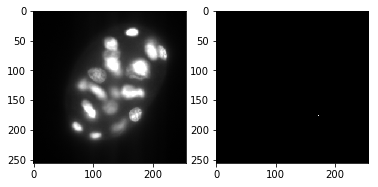

In [48]:
# plot 2 images to check that the labels are correct 
# DEBUG:
sample = 4
slice = 14
plt.Figure(figsize=(5, 3), dpi=300)
plt.subplot(121)
img1 = np.array(np_dataset_x_train[sample, :, : ,slice, 0], dtype=np.float32) # .astype(np.uint8)
plt.imshow(img1, cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.subplot(122)
img3 = np.array(np_dataset_l_train[sample, :, : ,slice, 0], dtype=np.float32) # .astype(np.uint8)
plt.imshow(img3, cmap=plt.get_cmap('gray'))
print(np.sum(img3) // 255)

In [50]:
# what is the plan here then? 
# = perfrom the slice-by-slice transformations  
# = reset the seed so that the value stays the same

# There are multiple problems with the feature generation for 3D images in keras 
# one of the important once is the fact that you can save only png and jpg images 
# but NOT tiff

# Write your own simple transformer:
# translate, rotate in x,y (z), horizontal_flip, vertical_flip


# DEBUG:
shift = 0.20
image_data_gen_args = dict(featurewise_center = False, 
                             featurewise_std_normalization = False, 
                             zca_whitening = False, 
                             rotation_range = 5,
                             width_shift_range = shift, 
                             height_shift_range = shift,
                             fill_mode = 'wrap',
                             # cval = 0,
                             horizontal_flip = False, 
                             vertical_flip = False)
datagen = ImageDataGenerator(**image_data_gen_args)

# perfrom the transformations on the same slice of all the images 
slice = 1
image_generator = datagen.flow(
    np_dataset_x_train[:,:,:,slice,:],
    seed=seed, 
    batch_size = batch_size,
    save_to_dir='data/aug', save_prefix='cell', save_format='tiff')


In [32]:
# in case of images and labels we have to use the following approach: 
# create 2 instances with the same arguments: 
shift = 0.02
image_data_gen_args = dict(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             # zca_whitening=True, 
                             rotation_range=5,
                             width_shift_range=shift, 
                             height_shift_range=shift,
                             fill_mode = 'wrap',
                             # cval = 0,
                             horizontal_flip=True, 
                             vertical_flip=True)

datagen = ImageDataGenerator(**image_data_gen_args)
labelgen = ImageDataGenerator(**image_data_gen_args)

# Only required if featurewise_center or featurewise_std_normalization or zca_whitening.
# datagen.fit(np_dataset_x_train, augment=True, seed=seed)
# labelgen.fit(np_dataset_l_train, augment=True, seed=seed)

image_generator = datagen.flow(
    np_dataset_x_train,
    seed=seed, 
    batch_size = batch_size,
    save_to_dir='data/aug', save_prefix='cell', save_format='png')
label_generator = labelgen.flow(
    np_dataset_l_train,
    seed=seed,
    batch_size = batch_size,
    save_to_dir='data/aug', save_prefix='dots', save_format='png')

j_batch = 0
for X_batch, y_batch in zip(image_generator, label_generator):
    print(j_batch, "th batch with the shapes:", X_batch.shape, y_batch.shape)     
    j_batch += 1;
    if (j_batch >= num_batches):
        break

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (5, 256, 256, 27, 1))